In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
import time, timeit

from procedure_notebook import Procedure, Hamiltonian
import measurables

In [2]:
proc = Procedure()

In [3]:
##Create frustrated hamiltonian
proc.setParameters(L = 5, J = -1, hx=0.2)

N_cycles = 30
setup_state_for_next_cycle = Procedure.pass_remake_product_state_with_xyz
using_state_vectors = False
using_density_matrices = True



eigenenergies, eigenstates = measurables.tfim_hamiltonian(proc.L, proc.tfim_parameters).eigenstates()

ground_energy = eigenenergies[0]
ground_states = []
for i in range(len(eigenenergies)):
    if np.round(eigenenergies[i], 8) == np.round(ground_energy, 8):
        eigenstates[i] = eigenstates[i].ptrace([i for i in range(proc.L)])
        ground_states.append(eigenstates[i] * eigenstates[i].dag())
    else:
        break 

def measure(state, proc):

    energy = qt.expect(measurables.tfim_hamiltonian(proc.L, proc.tfim_parameters), state)
    state = state.ptrace([i for i in range(proc.L)])
    
    product = 0
    for gstate in ground_states:
        product += Procedure.abs_squared_scalarproduct(state, gstate)

    return [energy, product]
 


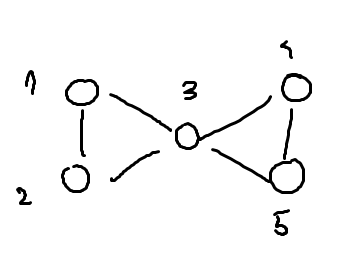

In [4]:
si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

sx_list = []
sy_list = []
sz_list = []

L = proc.L
N = 2*L
for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sx
    sx_list.append(qt.tensor(op_list))

    op_list[n] = sy
    sy_list.append(qt.tensor(op_list))

    op_list[n] = sz
    sz_list.append(qt.tensor(op_list))

J, hx, hz = proc.tfim_parameters
hx_list = np.ones(L) * hx
hz_list = np.ones(L) * hz

H_ising_chain = 0

for n in range(L):
        H_ising_chain += -hx_list[n] * sx_list[n]
        H_ising_chain += -hz_list[n] * sz_list[n]


H_ising_chain += - J * sz_list[0] * sz_list[1]
H_ising_chain += - J * sz_list[0] * sz_list[2]
H_ising_chain += - J * sz_list[1] * sz_list[2]
H_ising_chain += - J * sz_list[2] * sz_list[3]
H_ising_chain += - J * sz_list[2] * sz_list[4]
H_ising_chain += - J * sz_list[3] * sz_list[4]

In [5]:
times = np.arange(0,proc.T+proc.dt, proc.dt)

In [6]:
data = proc.runProcedure(N_cycles=N_cycles, measure=measure, chain_hamiltonian=H_ising_chain,
                          setup_state_for_next_cycle=setup_state_for_next_cycle,
                          coupling_decrease="use_default", using_state_vectors=using_state_vectors ,using_density_matrices=using_density_matrices)


True


Cycle:   0%|          | 0/30 [00:00<?, ?it/s]

sesolve:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
H_TFIM = measurables.tfim_hamiltonian(proc.L, proc.tfim_parameters)
M_TFIM = measurables.tfim_magnetisation(proc.L)

eigen_energies = H_TFIM.eigenenergies()

E0 = eigen_energies[0]
print("TFIM ground energy: ", E0)

In [ ]:
cmap = plt.get_cmap('jet')
COLORS = [cmap(i) for i in np.linspace(.01, .99, N_cycles)]

for i in range(len(data[0,:,0])):
    plt.plot(times, data[0,i,:], color=COLORS[i])

plt.axhline(y=E0, linestyle='--', color='black', label=r"$E_0$")

norm = mpl.colors.Normalize(vmin=0, vmax=N_cycles)
scalarmappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalarmappable, ax=plt.gca(), label="Cycle number")

plt.xlabel("Time (during single cycle)", fontsize = 15)
plt.ylabel("TFIM energy", fontsize = 15)
plt.title("TFIM energies during cycles", fontsize = 16)

In [ ]:
start_cycle_energies = data[0,:,0]
end_cycle_energies = data[0,:,-1]



plt.plot(start_cycle_energies, '--o', label="E (start)")
plt.plot(end_cycle_energies, '--o', label="E (end)")

#plt.axhline(y=E0, linestyle='--', color='black', label=r"$E_0$")

i = 0
j = 0
E = E0
while True:
    try:
        i += 1
        #print(f"{E}  {j}  {i}")
        if eigen_energies[i] > np.max(start_cycle_energies) and eigen_energies[i] > np.max(end_cycle_energies):
            break
        if np.round(eigen_energies[i], 2) == np.round(E,2):
            continue

        plt.axhline(y=eigen_energies[i], linestyle='--', color='gray')
        j += 1
        E = eigen_energies[i]
    except IndexError:
        break

J, hx, hz = proc.tfim_parameters


plt.legend(fontsize = 16)
plt.xlabel('Number of cycles', fontsize = 15)
plt.ylabel('Energy', fontsize = 15)
plt.title(fr'L={proc.L}, $\delta t$={proc.dt}, T={T}, J={J}', fontsize = 18) 